In [ ]:
import findspark

findspark.init(spark_home='/Users/zhanghousu/spark/spark-3.3.1-bin-hadoop2',
                python_path='/Users/zhanghousu/conda/bin/python')

from pyspark import SparkContext
sc = SparkContext()

In [1]:
# read file
lines = sc.textFile("movie/ratings.csv")

header = lines.first()
lines = lines.filter(lambda line: line != header)

# extract (movieId, rating)
movie_ratings = lines.map(lambda x: (int(x.split(',')[1]), float(x.split(',')[2])))

# group by movieId
grouped_ratings = movie_ratings.groupByKey()

# calculate average rating
avg_ratings = grouped_ratings.mapValues(lambda x: sum(x) / len(x))

# order by average rating
sorted_avg_ratings = avg_ratings.sortBy(lambda x: x[1], ascending=False)

# print top 10
results = sorted_avg_ratings.collect()

# for result in results:
#     print("MovieId: {}, Avg Rating: {:.2f}".format(result[0], result[1]))


In [2]:
perfect_ratings = avg_ratings.filter(lambda x: x[1] >= 3.5)

# Collect results and print
five_score = perfect_ratings.collect()


In [3]:
# for result in five_score:
from pyspark.sql import SparkSession
spark = SparkSession(sc)
perfect_ratings_df = spark.createDataFrame(five_score, schema=["movieId", "avg_rating"])
perfect_ratings_df.show(5)

+-------+------------------+
|movieId|        avg_rating|
+-------+------------------+
|    110| 4.016057252826558|
|    858| 4.339810758717364|
|  91542| 3.738952195664258|
| 112552| 4.120283855706682|
|   1210|3.9896115699843735|
+-------+------------------+
only showing top 5 rows



In [4]:
# read file
movi_df = spark.read.csv('movie/movies_metadata.csv', header=True, escape='"')
movi_df.show(10)

+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------------+---------+-------+--------------------+--------+--------------------+--------------------+-----+------------+----------+
|adult|belongs_to_collection|  budget|              genres|            homepage|   id|  imdb_id|original_language|      original_title|            overview|popularity|         poster_path|production_companies|production_countries|release_date|  revenue|runtime|    spoken_languages|  status|             tagline|               title|video|vote_average|vote_count|
+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------------+---------+-------+-----------

In [5]:
movi_df = movi_df["id","genres"]
movi_df.show(5)

+-----+--------------------+
|   id|              genres|
+-----+--------------------+
|  862|[{'id': 16, 'name...|
| 8844|[{'id': 12, 'name...|
|15602|[{'id': 10749, 'n...|
|31357|[{'id': 35, 'name...|
|11862|[{'id': 35, 'name...|
+-----+--------------------+
only showing top 5 rows



In [6]:
movi_df = movi_df.withColumnRenamed("id", "movieId")
movi_df = movi_df.drop("id")
movi_df.show(5)

+-------+--------------------+
|movieId|              genres|
+-------+--------------------+
|    862|[{'id': 16, 'name...|
|   8844|[{'id': 12, 'name...|
|  15602|[{'id': 10749, 'n...|
|  31357|[{'id': 35, 'name...|
|  11862|[{'id': 35, 'name...|
+-------+--------------------+
only showing top 5 rows



In [7]:
from pyspark.sql.functions import from_json, col, explode, \
    get_json_object, regexp_replace, array
from pyspark.sql.types import StructType, StructField, \
    StringType, IntegerType, ArrayType, MapType, DoubleType

json_schema = ArrayType(StructType([
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True)
]))

mv_ges = movi_df.withColumn('genres', regexp_replace("genres", 'None', "'None'"))
mv_ges = mv_ges.withColumn("genres_array", from_json(col("genres"), json_schema))

# explode
mv_ges = mv_ges.select(col("movieId"), explode(col("genres_array")).alias("genres_item"))

# extract
mv_ges_df = mv_ges.withColumn("genre_name", col("genres_item")["name"]) \
    .drop('genres_item')

mv_ges_df.show(5)


+-------+----------+
|movieId|genre_name|
+-------+----------+
|    862| Animation|
|    862|    Comedy|
|    862|    Family|
|   8844| Adventure|
|   8844|   Fantasy|
+-------+----------+
only showing top 5 rows



In [8]:
# join two dataframe
joined_df = perfect_ratings_df.join(mv_ges_df, on="movieId", how="inner")
joined_df = joined_df.drop("avg_rating")
joined_df.show(5)


+-------+----------+
|movieId|genre_name|
+-------+----------+
|    110|   Romance|
|    110|   Mystery|
|    110|     Drama|
|    858|   Romance|
|    858|     Drama|
+-------+----------+
only showing top 5 rows



In [ ]:
%pip install wheel setuptools --upgrade


In [ ]:
%pip install wordcloud==1.8.1 

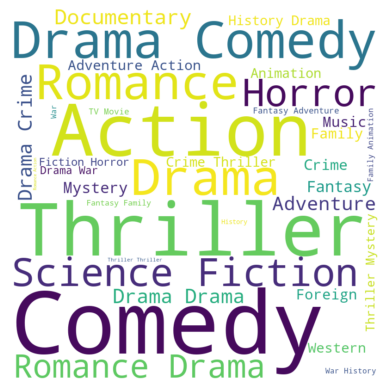

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 将DataFrame的genre_name列转换为一个Python列表
genre_name_list = joined_df.select("genre_name").rdd.flatMap(lambda x: x).collect()

# 将列表转换为单个字符串，用空格分隔每个genre_name
genre_name_text = " ".join(genre_name_list)

# 生成词云
wordcloud = WordCloud(background_color="white", width=800, height=800, margin=2).generate(genre_name_text)

# 显示词云
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
